# Legal LLM Fine-tuning Learning Guide

## What is Fine-tuning?

Fine-tuning is the process of taking a pre-trained language model and training it further on domain-specific data to improve its performance on particular tasks. For legal applications, this means:

1. **Starting with a base model**: We use pre-trained models like T5, BERT, or GPT that already understand language
2. **Training on legal data**: We feed the model legal documents, cases, and Q&A pairs
3. **Task specialization**: The model learns legal terminology, concepts, and reasoning patterns

## Why Fine-tune for Legal Data?

- **Domain expertise**: Legal language is highly specialized with specific terminology
- **Better accuracy**: Generic models may not understand legal nuances
- **Compliance**: Legal applications require high precision and reliability
- **Context understanding**: Legal reasoning often requires understanding precedents and constitutional principles

## Our Approach

We'll fine-tune Google's FLAN-T5 model on Indian Constitutional Q&A data to create a model that can:
- Answer questions about Indian constitutional law
- Understand legal terminology and concepts
- Provide accurate and relevant responses to legal queries

## Step 1: Exploring Our Legal Dataset

Let's first understand the structure and quality of our constitutional Q&A data.

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# Load the constitutional Q&A dataset
with open('constitution_qa.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

print(f"Total number of Q&A pairs: {len(data)}")
print("\nFirst few examples:")
for i, item in enumerate(data[:3]):
    print(f"\nExample {i+1}:")
    print(f"Question: {item['question']}")
    print(f"Answer: {item['answer']}")
    print("-" * 50)

Total number of Q&A pairs: 4082

First few examples:

Example 1:
Question: What is India according to the Union and its Territory?
Answer: India, that is Bharat, shall be a Union of States.
--------------------------------------------------

Example 2:
Question: How is India, that is Bharat, defined in terms of its political structure?
Answer: India, that is Bharat, is defined as a Union of States according to the Union and its Territory.
--------------------------------------------------

Example 3:
Question: What does the territory of India comprise of?
Answer: The territory of India shall comprise the territories of the States, the Union territories specified in the First Schedule, and such other territories as may be acquired.
--------------------------------------------------


Dataset shape: (4082, 2)

Column names: ['question', 'answer']

Text Length Statistics:
       question_length  answer_length  question_words  answer_words
count      4082.000000    4082.000000     4082.000000   4082.000000
mean        107.121509     145.096031       18.181284     24.548016
std          63.313252     132.887195       10.397725     22.401753
min          19.000000       1.000000        3.000000      1.000000
25%          67.000000      52.000000       12.000000      9.000000
50%          95.000000     110.000000       16.000000     19.000000
75%         129.000000     198.750000       22.000000     34.000000
max        1025.000000    1398.000000      136.000000    235.000000


/tmp/ipykernel_22902/301322759.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 1].boxplot(data_for_box, labels=['Questions', 'Answers'])


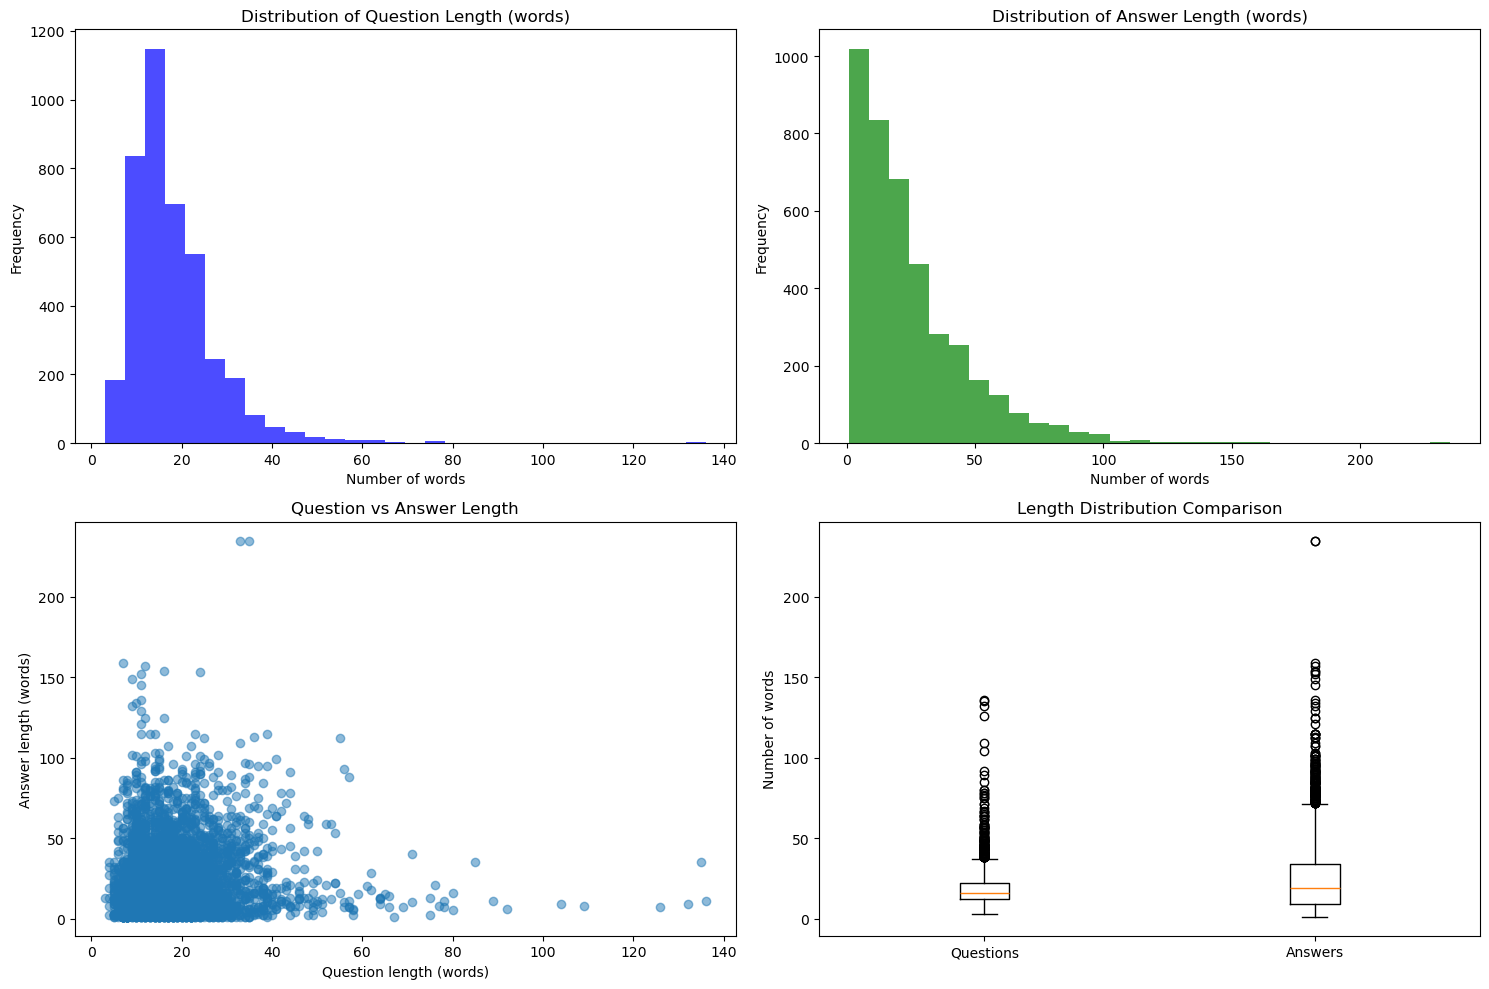

In [2]:
# Convert to DataFrame for easier analysis
df = pd.DataFrame(data)
print("Dataset shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

# Analyze text lengths
df['question_length'] = df['question'].str.len()
df['answer_length'] = df['answer'].str.len()
df['question_words'] = df['question'].str.split().str.len()
df['answer_words'] = df['answer'].str.split().str.len()

print("\nText Length Statistics:")
print(df[['question_length', 'answer_length', 'question_words', 'answer_words']].describe())

# Plot distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Question length distribution
axes[0, 0].hist(df['question_words'], bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title('Distribution of Question Length (words)')
axes[0, 0].set_xlabel('Number of words')
axes[0, 0].set_ylabel('Frequency')

# Answer length distribution
axes[0, 1].hist(df['answer_words'], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title('Distribution of Answer Length (words)')
axes[0, 1].set_xlabel('Number of words')
axes[0, 1].set_ylabel('Frequency')

# Question vs Answer length scatter
axes[1, 0].scatter(df['question_words'], df['answer_words'], alpha=0.5)
axes[1, 0].set_title('Question vs Answer Length')
axes[1, 0].set_xlabel('Question length (words)')
axes[1, 0].set_ylabel('Answer length (words)')

# Box plot comparison
data_for_box = [df['question_words'], df['answer_words']]
axes[1, 1].boxplot(data_for_box, labels=['Questions', 'Answers'])
axes[1, 1].set_title('Length Distribution Comparison')
axes[1, 1].set_ylabel('Number of words')

plt.tight_layout()
plt.show()

In [3]:
# Analyze legal terminology and key phrases
import re
from collections import Counter

# Combine all text for analysis
all_questions = ' '.join(df['question'].tolist())
all_answers = ' '.join(df['answer'].tolist())

# Find common legal terms (words that start with capital letters or specific legal terms)
legal_pattern = r'\b[A-Z][a-z]*\b|\b(?:Parliament|Constitution|State|Union|Bill|Act|Article|Schedule|Amendment|Court|Justice|Law|Right|Duty|Citizen|Government|Territory|President|Governor|Minister|Legislature|Judiciary|Executive)\b'

legal_terms_questions = re.findall(legal_pattern, all_questions)
legal_terms_answers = re.findall(legal_pattern, all_answers)

print("Most common legal terms in questions:")
question_counter = Counter(legal_terms_questions)
for term, count in question_counter.most_common(15):
    print(f"  {term}: {count}")

print("\nMost common legal terms in answers:")
answer_counter = Counter(legal_terms_answers)
for term, count in answer_counter.most_common(15):
    print(f"  {term}: {count}")

# Look for question patterns
question_starters = [q.split()[:3] for q in df['question'] if len(q.split()) >= 3]
question_starter_patterns = Counter([' '.join(starter) for starter in question_starters])

print("\nMost common question patterns (first 3 words):")
for pattern, count in question_starter_patterns.most_common(10):
    print(f"  '{pattern}': {count}")

Most common legal terms in questions:
  What: 2304
  State: 899
  Who: 732
  Constitution: 566
  India: 538
  Act: 477
  Council: 339
  President: 333
  Parliament: 293
  Which: 291
  Court: 286
  House: 250
  Union: 243
  Legislative: 204
  Legislature: 203

Most common legal terms in answers:
  The: 1991
  State: 1313
  President: 624
  Act: 568
  India: 532
  Parliament: 469
  Council: 419
  Constitution: 409
  Court: 388
  Governor: 380
  House: 368
  Legislature: 337
  Union: 327
  Legislative: 253
  Government: 236

Most common question patterns (first 3 words):
  'What is the': 693
  'What does the': 229
  'What are the': 121
  'Who has the': 113
  'What happens to': 108
  'What can the': 65
  'What happens if': 63
  'Who is responsible': 57
  'Which act is': 41
  'Under what conditions': 34


## Step 2: Understanding Fine-tuning Concepts

### Key Concepts You Need to Know:

**1. Base Model Selection:**
- **FLAN-T5**: A text-to-text model that's instruction-tuned (good for Q&A tasks)
- **BERT**: Good for classification and understanding tasks
- **GPT models**: Good for text generation
- For legal Q&A, T5 is excellent because it can handle instruction-following

**2. Data Formatting:**
- **Input format**: "Answer the question: [QUESTION]"
- **Target format**: "[ANSWER]"
- This teaches the model to respond to legal questions in a structured way

**3. Training Process:**
- **Tokenization**: Convert text to numbers the model understands
- **Batching**: Group examples for efficient training
- **Loss function**: Measures how wrong the model's predictions are
- **Optimization**: Adjusts model weights to reduce loss

**4. Evaluation Metrics:**
- **ROUGE**: Measures overlap between generated and reference answers
- **BLEU**: Another text similarity metric
- **Perplexity**: How "surprised" the model is by the correct answer

### Data Preparation Steps:

In [4]:
# Step 1: Format data for instruction-following
def format_instruction(question, answer):
    """
    Format a Q&A pair into instruction-following format for T5
    """
    # Create an instruction-style input
    instruction = f"Answer the following question about Indian constitutional law: {question}"
    return {
        'input_text': instruction,
        'target_text': answer
    }

# Apply formatting to our dataset
formatted_data = []
for item in data:
    formatted_item = format_instruction(item['question'], item['answer'])
    formatted_data.append(formatted_item)

print("Examples of formatted data:")
for i, item in enumerate(formatted_data[:3]):
    print(f"\nExample {i+1}:")
    print(f"Input: {item['input_text']}")
    print(f"Target: {item['target_text']}")
    print("-" * 80)

print(f"\nTotal formatted examples: {len(formatted_data)}")

Examples of formatted data:

Example 1:
Input: Answer the following question about Indian constitutional law: What is India according to the Union and its Territory?
Target: India, that is Bharat, shall be a Union of States.
--------------------------------------------------------------------------------

Example 2:
Input: Answer the following question about Indian constitutional law: How is India, that is Bharat, defined in terms of its political structure?
Target: India, that is Bharat, is defined as a Union of States according to the Union and its Territory.
--------------------------------------------------------------------------------

Example 3:
Input: Answer the following question about Indian constitutional law: What does the territory of India comprise of?
Target: The territory of India shall comprise the territories of the States, the Union territories specified in the First Schedule, and such other territories as may be acquired.
--------------------------------------------

In [5]:
# Step 2: Split data into train/validation/test sets
from sklearn.model_selection import train_test_split
import random

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# First split: separate test set (15%)
train_val_data, test_data = train_test_split(formatted_data, test_size=0.15, random_state=42)

# Second split: separate validation from training (20% of remaining data)
train_data, val_data = train_test_split(train_val_data, test_size=0.2, random_state=42)

print("Data split sizes:")
print(f"Training set: {len(train_data)} examples ({len(train_data)/len(formatted_data)*100:.1f}%)")
print(f"Validation set: {len(val_data)} examples ({len(val_data)/len(formatted_data)*100:.1f}%)")
print(f"Test set: {len(test_data)} examples ({len(test_data)/len(formatted_data)*100:.1f}%)")

# Why split data?
print("""
Why do we split data?

1. **Training Set (68%)**: Used to train the model - the model learns from these examples
2. **Validation Set (17%)**: Used during training to:
   - Monitor overfitting (when model memorizes rather than learns)
   - Tune hyperparameters (learning rate, batch size, etc.)
   - Decide when to stop training (early stopping)
3. **Test Set (15%)**: Used ONLY at the end to evaluate final model performance
   - Gives unbiased estimate of how model will perform on new data
   - Never used during training or validation
""")

# Save the splits for later use
import pickle

with open('data_splits.pkl', 'wb') as f:
    pickle.dump({
        'train': train_data,
        'val': val_data,
        'test': test_data
    }, f)

print("Data splits saved to 'data_splits.pkl'")

Data split sizes:
Training set: 2775 examples (68.0%)
Validation set: 694 examples (17.0%)
Test set: 613 examples (15.0%)

Why do we split data?

1. **Training Set (68%)**: Used to train the model - the model learns from these examples
2. **Validation Set (17%)**: Used during training to:
   - Monitor overfitting (when model memorizes rather than learns)
   - Tune hyperparameters (learning rate, batch size, etc.)
   - Decide when to stop training (early stopping)
3. **Test Set (15%)**: Used ONLY at the end to evaluate final model performance
   - Gives unbiased estimate of how model will perform on new data
   - Never used during training or validation

Data splits saved to 'data_splits.pkl'


## Step 3: Next Steps

Now that you understand the data preparation process, let's run these cells to see our data in action!

After running this notebook, you'll be ready to move to the `legal_llm_finetune_t5.ipynb` notebook which will:

1. **Load the model**: Download and initialize FLAN-T5-small
2. **Tokenize data**: Convert text to model-readable format
3. **Set up training**: Configure training parameters
4. **Train the model**: Fine-tune on your legal data
5. **Evaluate**: Test the model's performance
6. **Save and use**: Save the trained model and test it

### Key Learning Points:

- **Domain specialization**: Legal text has unique patterns and terminology
- **Instruction tuning**: Teaching the model to follow question-answering format
- **Data quality**: Clean, well-formatted data leads to better models
- **Evaluation**: Always test your model objectively

Click "Run All" above to execute all cells and see your data analysis!